<a href="https://colab.research.google.com/github/furusawa-ryoji/MNIST/blob/develop/%E6%96%87%E5%AD%97%E8%AA%8D%E8%AD%98%E3%80%80MNIST_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# kaggleの評価
データセットは1枚の画像のピクセルが784(28*28)列で表現されている(0,1で白黒判定かどうかはまだ調べていないがおそらくそう)

提出方法はIdとテストデータを予測した手書き文字の2列のCSVファイル

評価方法はどれだけ予想した手書き文字が合っているかで判定(97%正答なら0.97と表示)
一番いいのは1.00

In [1]:
# ZIPファイル解凍
!unzip digit*

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [24]:
import pandas as pd
import numpy as np

# データの読み込み
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.shape)
print(test_df.shape)

(42000, 785)
(28000, 784)


In [25]:
# データの確認
train_df.info

<bound method DataFrame.info of        label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
0          1       0       0       0  ...         0         0         0         0
1          0       0       0       0  ...         0         0         0         0
2          1       0       0       0  ...         0         0         0         0
3          4       0       0       0  ...         0         0         0         0
4          0       0       0       0  ...         0         0         0         0
...      ...     ...     ...     ...  ...       ...       ...       ...       ...
41995      0       0       0       0  ...         0         0         0         0
41996      1       0       0       0  ...         0         0         0         0
41997      7       0       0       0  ...         0         0         0         0
41998      6       0       0       0  ...         0         0         0         0
41999      9       0       0       0  ...         0         0     

In [26]:
# データフレームを配列に出来ているか確認
train_data = np.array(train_df)
test = np.array(test_df)
print(train_data)
print(test)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [7 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 [9 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [27]:
# ラベルと目的変数の定義
label = train_data[:, 0]
train = train_data[:,1:]
print(train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [28]:
# 画像は1行→28*28にreshapeする必要がある
train = train.reshape(len(train), 28, 28, 1)
test = test.reshape(len(test), 28, 28, 1)
X_train = train
X_test = test
# print(train)
# print(test)
# print(train.shape)
# print(test.shape)

In [29]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# クロスバリデーション(トレーニングデータを5つに分割)
kf = KFold(n_splits=5, shuffle=True)

# 多クラス分類のときにクラスのラベルをそのまま推論させない
# One-Hot表現に変換し、各クラスに分類される確率を出す。
# 0～9の数字のラベルに分類する？
from keras.utils import to_categorical
y_train = to_categorical(label, 10)

for train_index, eval_index in kf.split(X_train):
    X_tra, X_eval = X_train[train_index], X_train[eval_index]
    y_tra, y_eval = y_train[train_index], y_train[eval_index]

# データを正規化
x_tra = X_tra / 255
x_eval = X_eval / 255

In [30]:
print(y_train)
print(y_train.shape)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(42000, 10)


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
# 画像の表示:imshow(行)→28*28にすればいいのではないか？
# plt.imshow(train[300])

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.datasets import mnist
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

In [33]:
# モデルを作成：精度を上げるためにはここが一番重要
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

# 学習のためのモデルを設定
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.0001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

In [34]:
# 学習
result = model.fit(x_tra, y_tra,
           epochs=100,
          validation_data=(x_eval, y_eval)
           )

print('')
# 精度を検証
model.evaluate(x_eval, y_eval)

print('')
# 学習状況のログを表示
history = result.history
# vars(model.history)['history']

Epoch 1/100
1050/1050 [==============================] - 4s 3ms/step - loss: 2.3149 - accuracy: 0.0897 - val_loss: 2.3019 - val_accuracy: 0.0989
Epoch 2/100
1050/1050 [==============================] - 3s 3ms/step - loss: 2.2974 - accuracy: 0.1108 - val_loss: 2.2840 - val_accuracy: 0.1275
Epoch 3/100
1050/1050 [==============================] - 3s 3ms/step - loss: 2.2802 - accuracy: 0.1364 - val_loss: 2.2662 - val_accuracy: 0.1577
Epoch 4/100
1050/1050 [==============================] - 3s 3ms/step - loss: 2.2633 - accuracy: 0.1676 - val_loss: 2.2475 - val_accuracy: 0.2104
Epoch 5/100
1050/1050 [==============================] - 3s 3ms/step - loss: 2.2449 - accuracy: 0.2065 - val_loss: 2.2270 - val_accuracy: 0.2892
Epoch 6/100
1050/1050 [==============================] - 3s 3ms/step - loss: 2.2250 - accuracy: 0.2539 - val_loss: 2.2036 - val_accuracy: 0.3688
Epoch 7/100
1050/1050 [==============================] - 3s 3ms/step - loss: 2.2022 - accuracy: 0.3101 - val_loss: 2.1762 - val_ac

In [35]:
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


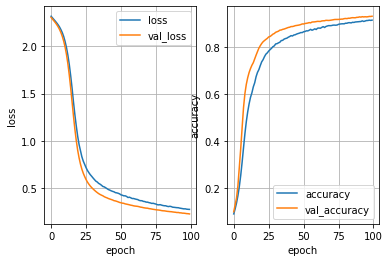

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

# 学習曲線を表示する→どうやって表示させるんだっけ？historyをインスタンス化して列名取得じゃダメなの？
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(history['loss'], label='loss')
ax1.plot(history['val_loss'], label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(history['accuracy'], label='accuracy')
ax2.plot(history['val_accuracy'], label='val_accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
ax2.grid()

In [43]:
# テストデータの予測
results = model.predict(test)
# カテゴリー分類されたテストデータの最大値のインデックス(右から順に数えて何番目かを返す)
results = np.argmax(results,axis = 1)
# npの配列のままなので、データフレームの形に直して名前を付ける
results = pd.Series(results, name="Label")
# 一応できているか確認
print(results)
print(results.shape)

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("CNN_submission.csv",index=False)

0        2
1        0
2        9
3        9
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64
(28000,)


In [45]:
sub_df = pd.read_csv('CNN_submission.csv')
print(sub_df.shape)
print(sub_df)

(28000, 2)
       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      9
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]


In [ ]:
# # CREATE MORE IMAGES VIA DATA AUGMENTATION
# datagen = ImageDataGenerator(
#         # rotation_range: 整数．画像をランダムに回転する回転範囲．
#         rotation_range=10,  
#         # zoom_range: 浮動小数点数または[lower，upper]．ランダムにズームする範囲．浮動小数点数が与えられた場合，[lower, upper] = [1-zoom_range, 1+zoom_range]
#         zoom_range = 0.10,  
#         # width_shift_range: 浮動小数点数（横幅に対する割合）．ランダムに水平シフトする範囲．
#         width_shift_range=0.1, 
#         # height_shift_range: 浮動小数点数（縦幅に対する割合）．ランダムに垂直シフトする範囲．
#         height_shift_range=0.1)